# 0 - Strategy

The objectives of this notebook are:
1. Efficiently pre-process data before using models.
2. Test different models to decide which will be put into production later on.

# 1 - Importation

## 1.1 Main libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, rcParams, style
import seaborn as sns

import folium
from folium.plugins import MarkerCluster
from scipy.spatial import cKDTree

# Time series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb

## 1.2 Settings

In [3]:
# Viualisation options to put here
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

## 1.3 Datasets load and setup

In [4]:
train = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/train.csv')
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d %H:%M:%S')
train.set_index('datetime', inplace=True)
train.drop(columns=['data_block_id','row_id'],inplace=True)
train.head(2)

,county,is_business,product_type,target,is_consumption,prediction_unit_id
datetime,,,,,,
2021-09-01,0,0,1,0.713,0,0
2021-09-01,0,0,1,96.590,1,0


In [5]:
gas_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/gas_prices.csv')
gas_price['forecast_date'] = pd.to_datetime(gas_price['forecast_date'], format='%Y-%m-%d')
gas_price = gas_price.set_index('forecast_date').resample('H').ffill()
gas_price.drop(columns=['origin_date','data_block_id'],inplace=True)
gas_price.head(2)

,lowest_price_per_mwh,highest_price_per_mwh
forecast_date,,
2021-09-01 00:00:00,45.23,46.32
2021-09-01 01:00:00,45.23,46.32


In [6]:
elec_price = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/electricity_prices.csv')
elec_price['forecast_date'] = pd.to_datetime(elec_price['forecast_date'], format='%Y-%m-%d %H:%M:%S')
elec_price.set_index('forecast_date', inplace=True)
elec_price.drop(columns=['origin_date','data_block_id'],inplace=True)
elec_price.head(2)

,euros_per_mwh
forecast_date,
2021-09-01 00:00:00,92.51
2021-09-01 01:00:00,88.90


In [7]:
# This dataset won't be used since we have historical data, which are the true data
weather_forecast = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/forecast_weather.csv')
weather_forecast.head(2)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.0,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.0,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [8]:
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/final_county_mapping.csv.xls')
station.head()

,county_name,latitude,longitude,county
0,UNKNOWN,57.6,21.7,12
1,SAAREMAA,57.9,21.7,10
2,SAAREMAA,58.2,21.7,10
3,SAAREMAA,58.4,21.7,10
4,UNKNOWN,58.7,21.7,12


In [9]:
station = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/weather_station_to_county_mapping.csv')

# Create a unique column for each coordinate pair
station['city'] = pd.factorize(station[['latitude','longitude']].apply(tuple,axis=1))[0]
station.head(2)

,county_name,longitude,latitude,county,city
0,NaN,21.7,57.6,NaN,0
1,NaN,21.7,57.9,NaN,1


In [10]:
client = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/client.csv')
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [11]:
weather_hist = pd.read_csv('/Users/kevinboulliat/Desktop/Data Science/predict-energy-behavior-of-prosumers/Train_files/historical_weather.csv')
weather_hist['datetime'] = pd.to_datetime(weather_hist['datetime'], format='%Y-%m-%d %H:%M:%S')
weather_hist.set_index('datetime', inplace=True)
weather_hist.head(2)

,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
datetime,,,,,,,,,,,,,,,,,
2021-09-01,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
2021-09-01,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0


In [12]:
def dataset_presentation(df):
    '''A very basic function to detail the shape of a given datasets amd also to notify if some columns contains missing values
    '''

    #Usefull variables
    shape = df.shape
    columns_to_clean = []

    #General comments
    print(' '*20)
    print(' '*20)
    print('General introduction')

    print(' '*20)
    print (f'Shape : {shape}')
    print(' '*20)

    #Details per column
    for column in df.columns :
        percentage_null = df[column].isnull().sum()/shape[0]
        c_type = df[column].dtype

        print('-'*20)
        print (f'{column} is the following type : {c_type}')
        print (f'{column} percentage missinge value : {percentage_null}%')
        print('-'*20)

        #Store columns with missing values to clean later
        if percentage_null > 0 :
            columns_to_clean.append(column)

    if len(columns_to_clean) == 0 :
        print('Lucky, no column to clean because of missing values ✅')

    else :
        print('You have to deal with some missing values ❌')
        print(f'columns to deal with are the following {columns_to_clean}')


# 2 - Group datasets together

In [13]:
weather_hist2 = weather_hist.copy()

tree = cKDTree(station[['latitude', 'longitude']].values)

# For each point in the weather_hist dataset, find the nearest point in the station dataset.
distances, indices = tree.query(weather_hist2[['latitude', 'longitude']].values)

# Add city name to weather_hist dataset
weather_hist2['county'] = station.loc[indices, 'county'].values

In [14]:
train2 = train.copy()

#Create a date column to merge easily the datasets together
train2['date'] = train2.index.date
train2['date'] = pd.to_datetime(train2['date'], format='%Y-%m-%d')

#Remove rows that are not in the other datasets
train2 = train2[train2['date'] != '2023-05-31']

In [15]:
#Group weather data and merge with the trainset
weather_hist_grouped = weather_hist2.groupby(['datetime','county']).mean()
df_merged1 = train2.merge(weather_hist_grouped, on=['datetime','county'], how='inner')
df_merged1.head()

,county,is_business,product_type,target,is_consumption,prediction_unit_id,date,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
datetime,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-01,0,0,1,0.713,0,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0
2021-09-01,0,0,1,96.590,1,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0
2021-09-01,0,0,2,0.000,0,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0
2021-09-01,0,0,2,17.314,1,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0
2021-09-01,0,0,3,2.904,0,2,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0


In [16]:
#Merge elec data with the main set
df_merged2 = df_merged1.merge(elec_price, right_index=True, left_index=True, how='inner')
df_merged2.head()

,county,is_business,product_type,target,is_consumption,prediction_unit_id,date,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,euros_per_mwh
2021-09-01,0,0,1,0.713,0,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51
2021-09-01,0,0,1,96.590,1,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51
2021-09-01,0,0,2,0.000,0,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51
2021-09-01,0,0,2,17.314,1,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51
2021-09-01,0,0,3,2.904,0,2,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51


In [17]:
#Merge gas data with main set
df_merged3 = df_merged2.merge(gas_price, right_index=True, left_index=True, how='left')
df_merged3.head()

,county,is_business,product_type,target,is_consumption,prediction_unit_id,date,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
2021-09-01,0,0,1,0.713,0,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,1,96.590,1,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,2,0.000,0,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,2,17.314,1,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,3,2.904,0,2,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32


# 3 - Preprocessing

In [18]:
dataset_presentation(df_merged3)

                    
                    
General introduction
                    
Shape : (1982730, 27)
                    
--------------------
county is the following type : int64
county percentage missinge value : 0.0%
--------------------
--------------------
is_business is the following type : int64
is_business percentage missinge value : 0.0%
--------------------
--------------------
product_type is the following type : int64
product_type percentage missinge value : 0.0%
--------------------
--------------------
target is the following type : float64
target percentage missinge value : 0.0002622646552985026%
--------------------
--------------------
is_consumption is the following type : int64
is_consumption percentage missinge value : 0.0%
--------------------
--------------------
prediction_unit_id is the following type : int64
prediction_unit_id percentage missinge value : 0.0%
--------------------
--------------------
date is the following type : datetime64[ns]
date percent

## 3.1 - Missing values

### 3.1.1 - Target missing values

In [19]:
target_missing = df_merged3[df_merged3['target'].isna() == True]
print(f'Number of missing rows for the column target: {target_missing.shape[0]} rows')
print(f'As a reminder, the total number of rows in our main dataset is: {df_merged3.shape[0]} rows')

Number of missing rows for the column target: 520 rows
As a reminder, the total number of rows in our main dataset is: 1982730 rows


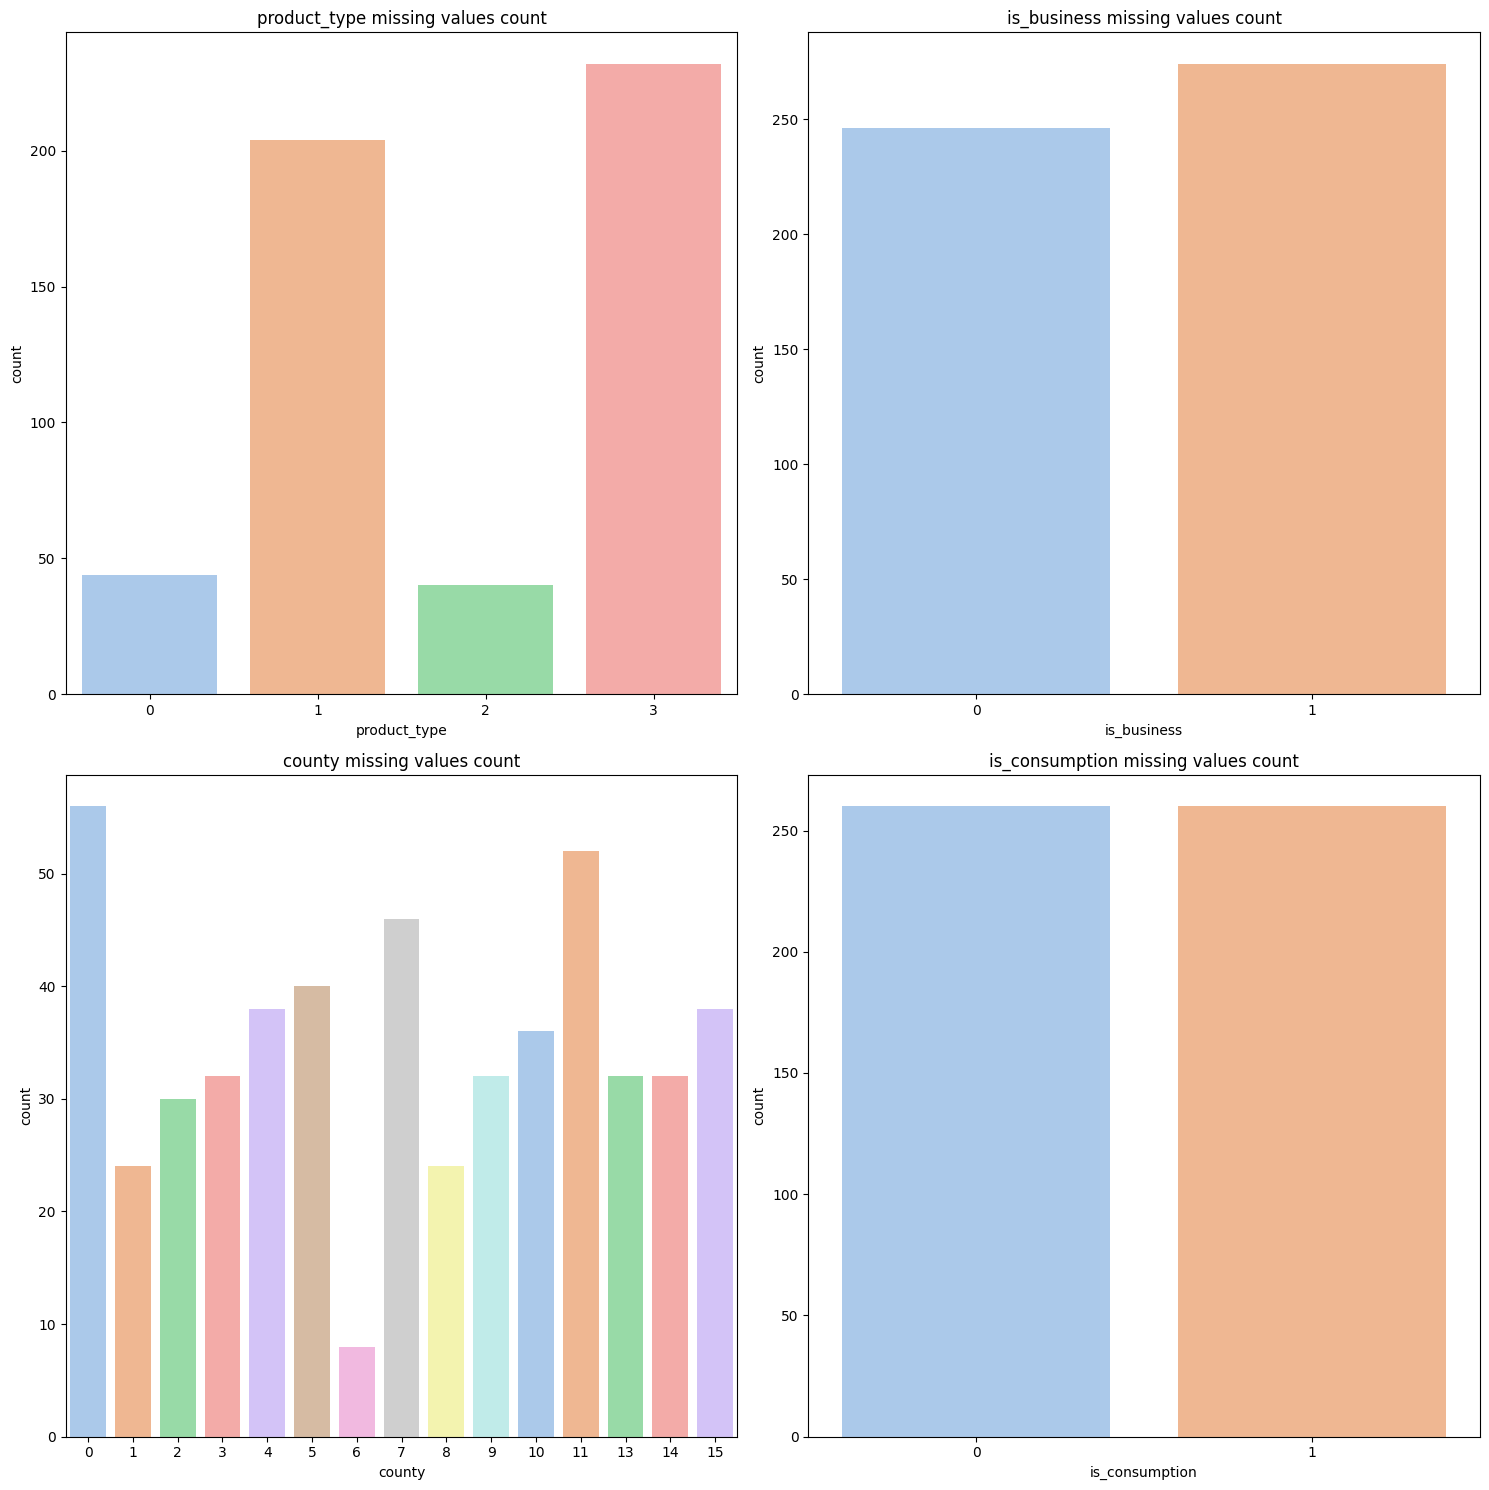

In [20]:
# Visualize the characteristics of missing data to highlight interesting insights

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


sns.countplot(data=target_missing, x='product_type', ax=ax1, palette='pastel')
ax1.set_title('product_type missing values count')

sns.countplot(data=target_missing, x='is_business', ax=ax2, palette='pastel')
ax2.set_title('is_business missing values count')

sns.countplot(data=target_missing, x='county', ax=ax3, palette='pastel')
ax3.set_title('county missing values count')

sns.countplot(data=target_missing, x='is_consumption', ax=ax4, palette='pastel')
ax4.set_title('is_consumption missing values count')

plt.tight_layout()
plt.show()

In [21]:
#Create date features
target_missing['year'] = target_missing.index.year
target_missing['month'] = target_missing.index.month
target_missing['week_day'] = target_missing.index.weekday
target_missing['week_year'] = target_missing.index.weekofyear

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/224820456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_missing['year'] = target_missing.index.year
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/224820456.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_missing['month'] = target_missing.index.month
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/224820456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

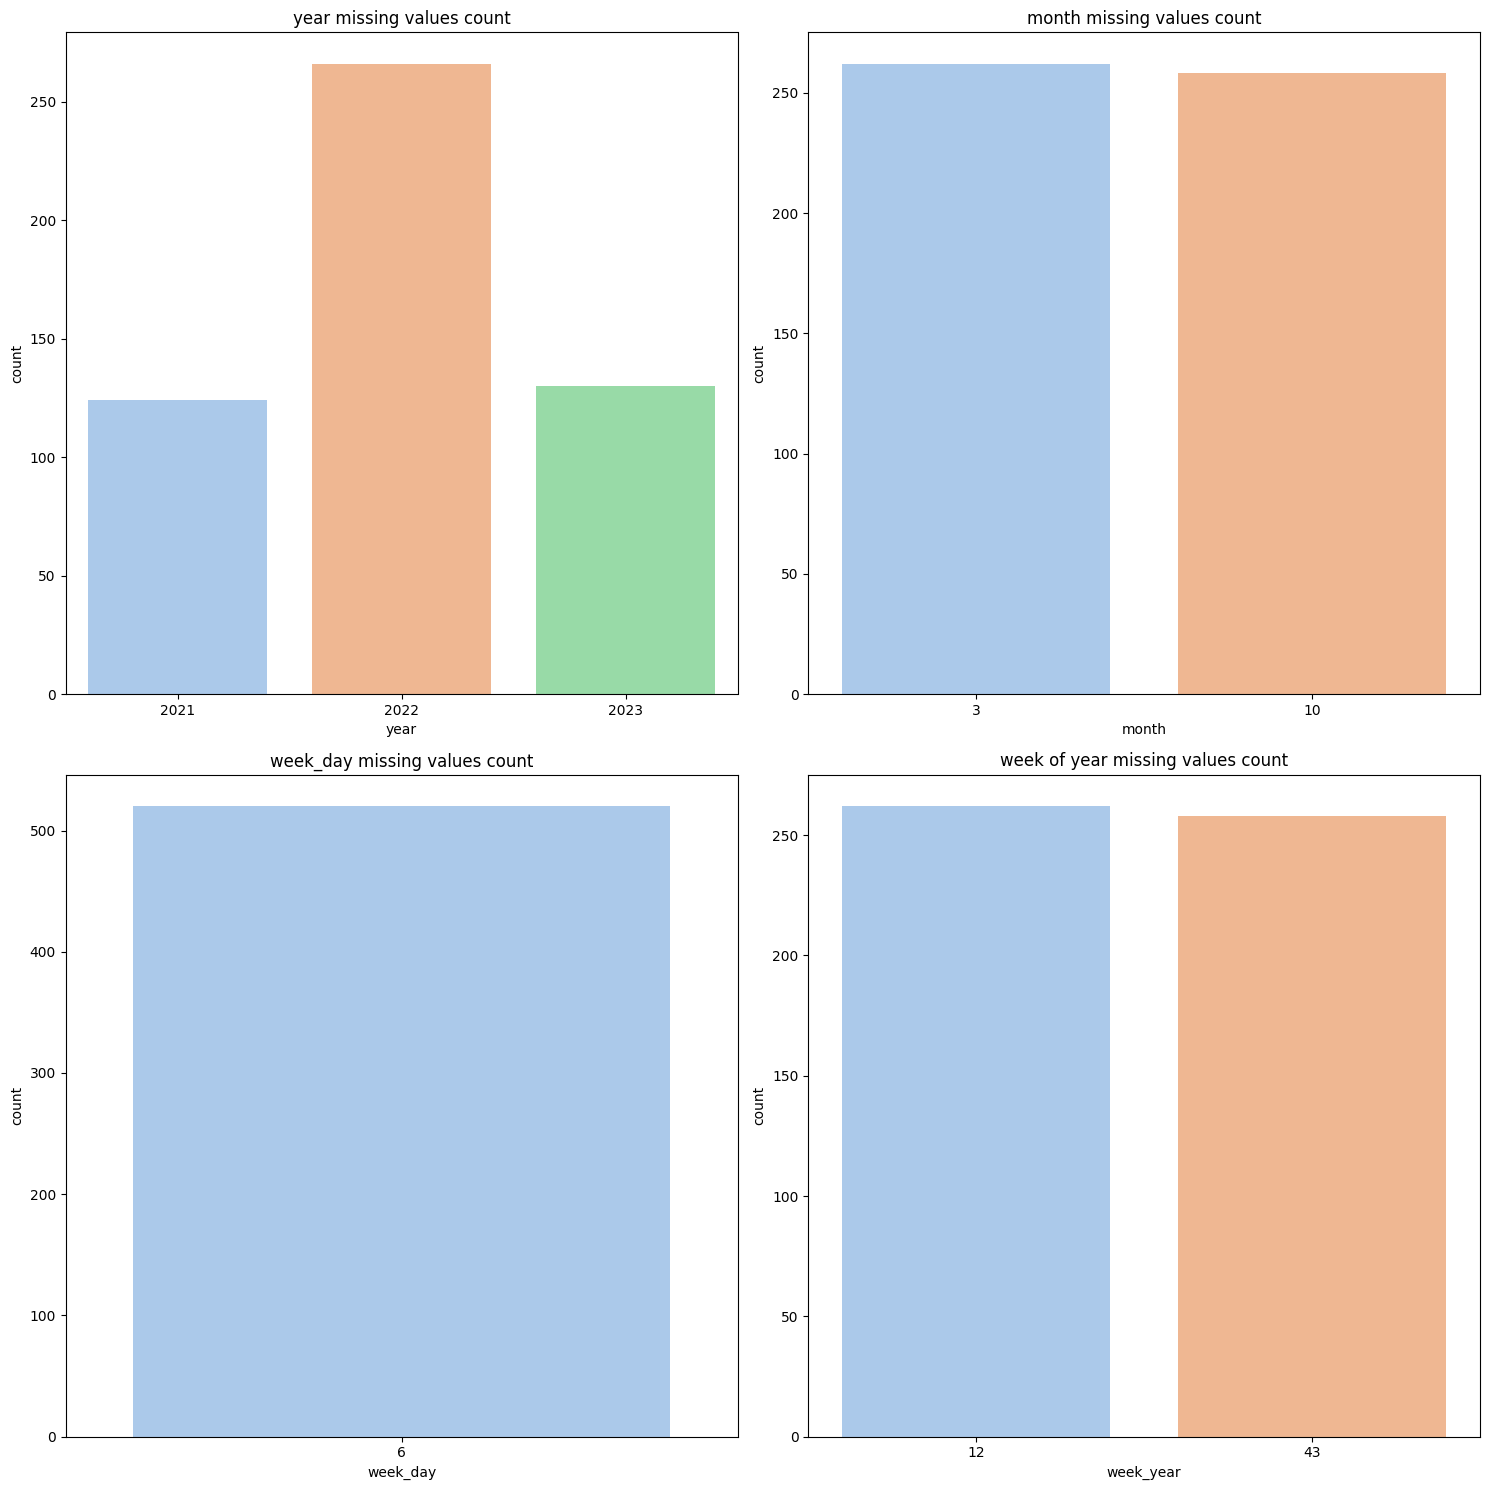

In [22]:
# Visualize the date type characteristics of missing data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


sns.countplot(data=target_missing, x='year', ax=ax1, palette='pastel')
ax1.set_title('year missing values count')

sns.countplot(data=target_missing, x='month', ax=ax2, palette='pastel')
ax2.set_title('month missing values count')

sns.countplot(data=target_missing, x='week_day', ax=ax3, palette='pastel')
ax3.set_title('week_day missing values count')

sns.countplot(data=target_missing, x='week_year', ax=ax4, palette='pastel')
ax4.set_title('week of year missing values count')

plt.tight_layout()
plt.show()

### 3.1.2 - Gas missing values

We will reproduce the same process below with the missing values in the gas set

In [23]:
gas_missing = df_merged3[df_merged3['lowest_price_per_mwh'].isna() == True]
print(f'Number of missing rows for the column target: {gas_missing.shape[0]} rows')
print(f'As a reminder, the total number of rows in our main dataset is: {df_merged3.shape[0]} rows')

Number of missing rows for the column target: 1280 rows
As a reminder, the total number of rows in our main dataset is: 1982730 rows


In [24]:
gas_missing.head()

,county,is_business,product_type,target,is_consumption,prediction_unit_id,date,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
2023-05-30 01:00:00,0,0,1,6.532,0,0,2023-05-30,8.216667,1.816667,0.0,0.0,1012.833333,57.333333,1.0,87.5,12.666667,2.87963,266.833333,0.0,0.0,0.0,59.3,24.866667,637.0,8.06,NaN,NaN
2023-05-30 01:00:00,0,0,1,465.981,1,0,2023-05-30,8.216667,1.816667,0.0,0.0,1012.833333,57.333333,1.0,87.5,12.666667,2.87963,266.833333,0.0,0.0,0.0,59.3,24.866667,637.0,8.06,NaN,NaN
2023-05-30 01:00:00,0,0,2,0.000,0,1,2023-05-30,8.216667,1.816667,0.0,0.0,1012.833333,57.333333,1.0,87.5,12.666667,2.87963,266.833333,0.0,0.0,0.0,59.3,24.866667,637.0,8.06,NaN,NaN
2023-05-30 01:00:00,0,0,2,3.987,1,1,2023-05-30,8.216667,1.816667,0.0,0.0,1012.833333,57.333333,1.0,87.5,12.666667,2.87963,266.833333,0.0,0.0,0.0,59.3,24.866667,637.0,8.06,NaN,NaN
2023-05-30 01:00:00,0,0,3,11.296,0,2,2023-05-30,8.216667,1.816667,0.0,0.0,1012.833333,57.333333,1.0,87.5,12.666667,2.87963,266.833333,0.0,0.0,0.0,59.3,24.866667,637.0,8.06,NaN,NaN


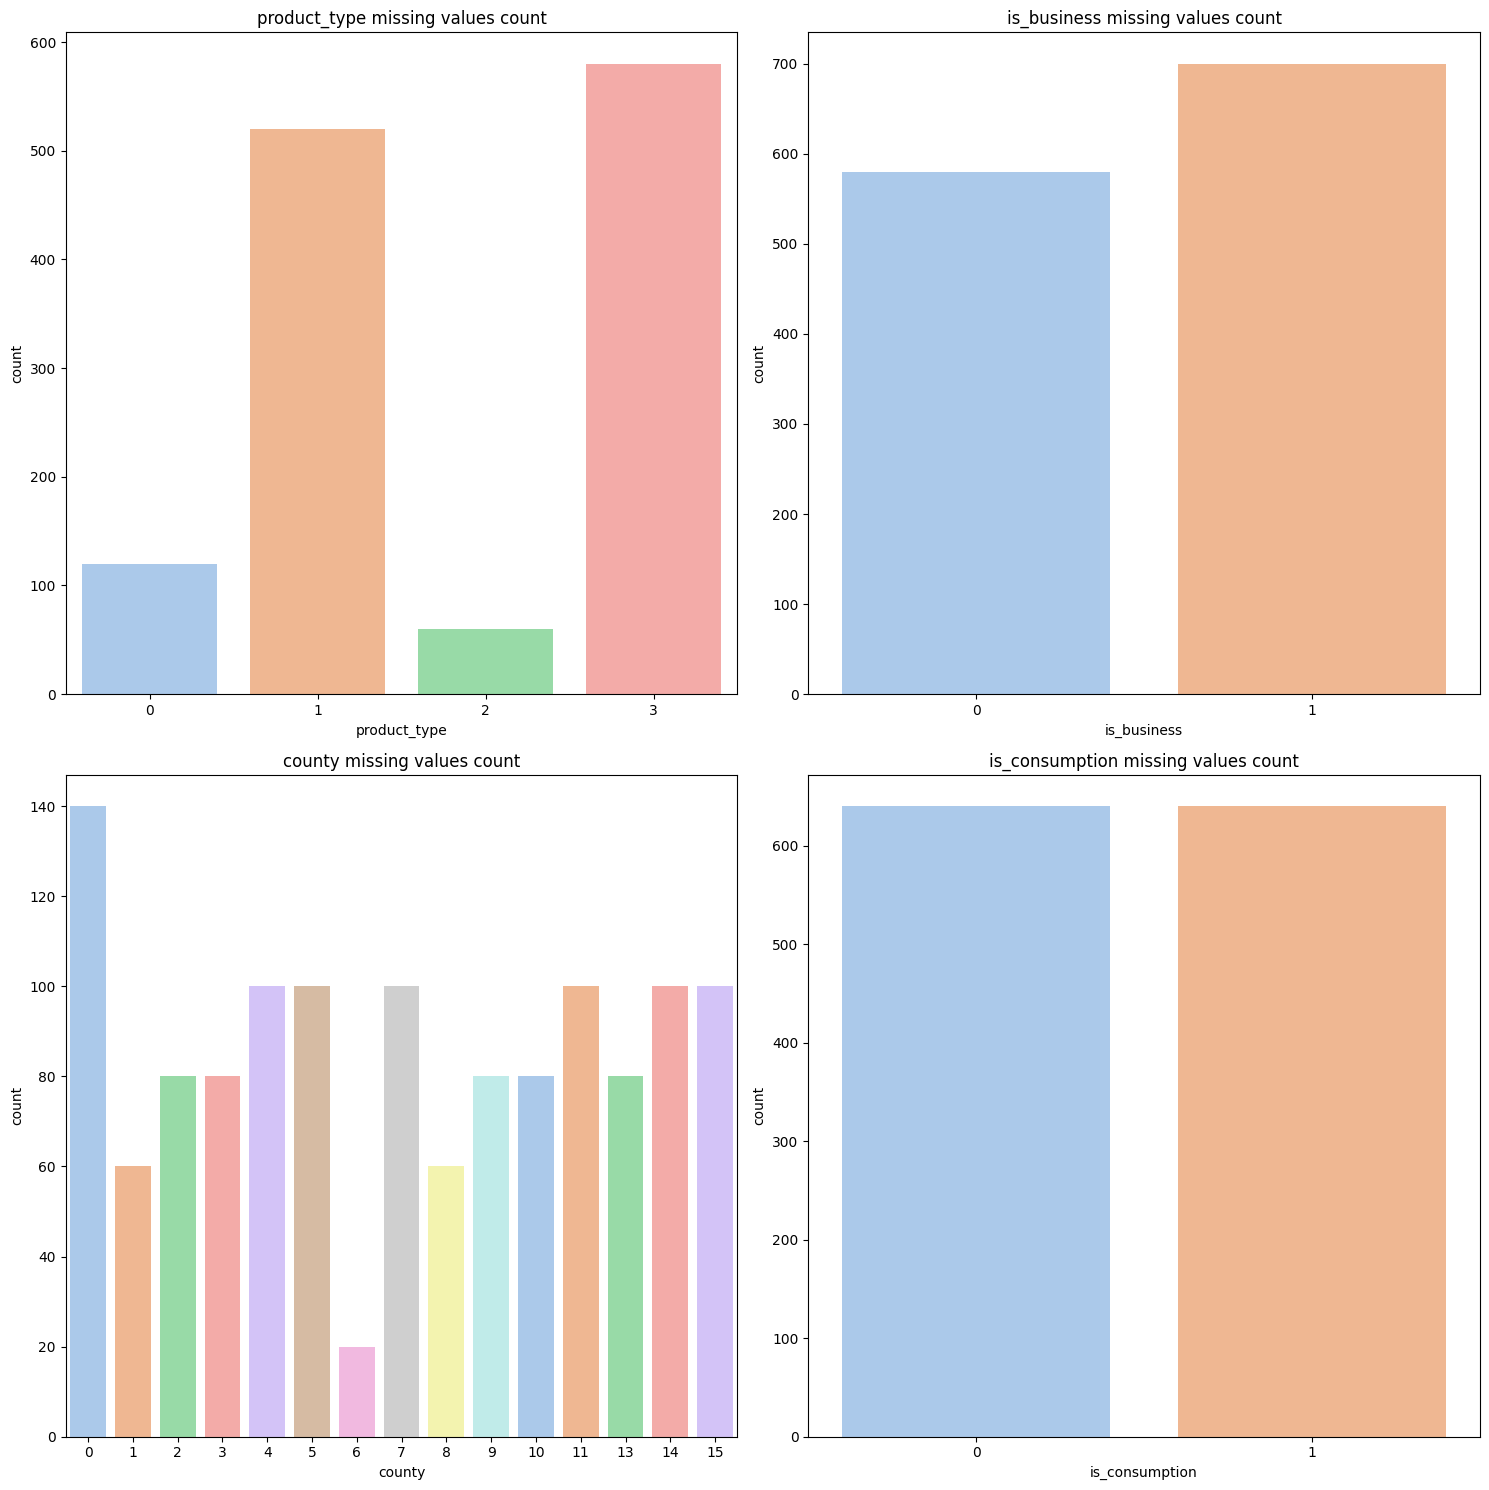

In [25]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


sns.countplot(data=gas_missing, x='product_type', ax=ax1, palette='pastel')
ax1.set_title('product_type missing values count')

sns.countplot(data=gas_missing, x='is_business', ax=ax2, palette='pastel')
ax2.set_title('is_business missing values count')

sns.countplot(data=gas_missing, x='county', ax=ax3, palette='pastel')
ax3.set_title('county missing values count')

sns.countplot(data=gas_missing, x='is_consumption', ax=ax4, palette='pastel')
ax4.set_title('is_consumption missing values count')

plt.tight_layout()
plt.show()

In [26]:
gas_missing['year'] = gas_missing.index.year
gas_missing['month'] = gas_missing.index.month
gas_missing['week_day'] = gas_missing.index.weekday
gas_missing['week_year'] = gas_missing.index.weekofyear

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/1094377483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_missing['year'] = gas_missing.index.year
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/1094377483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gas_missing['month'] = gas_missing.index.month
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/1094377483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

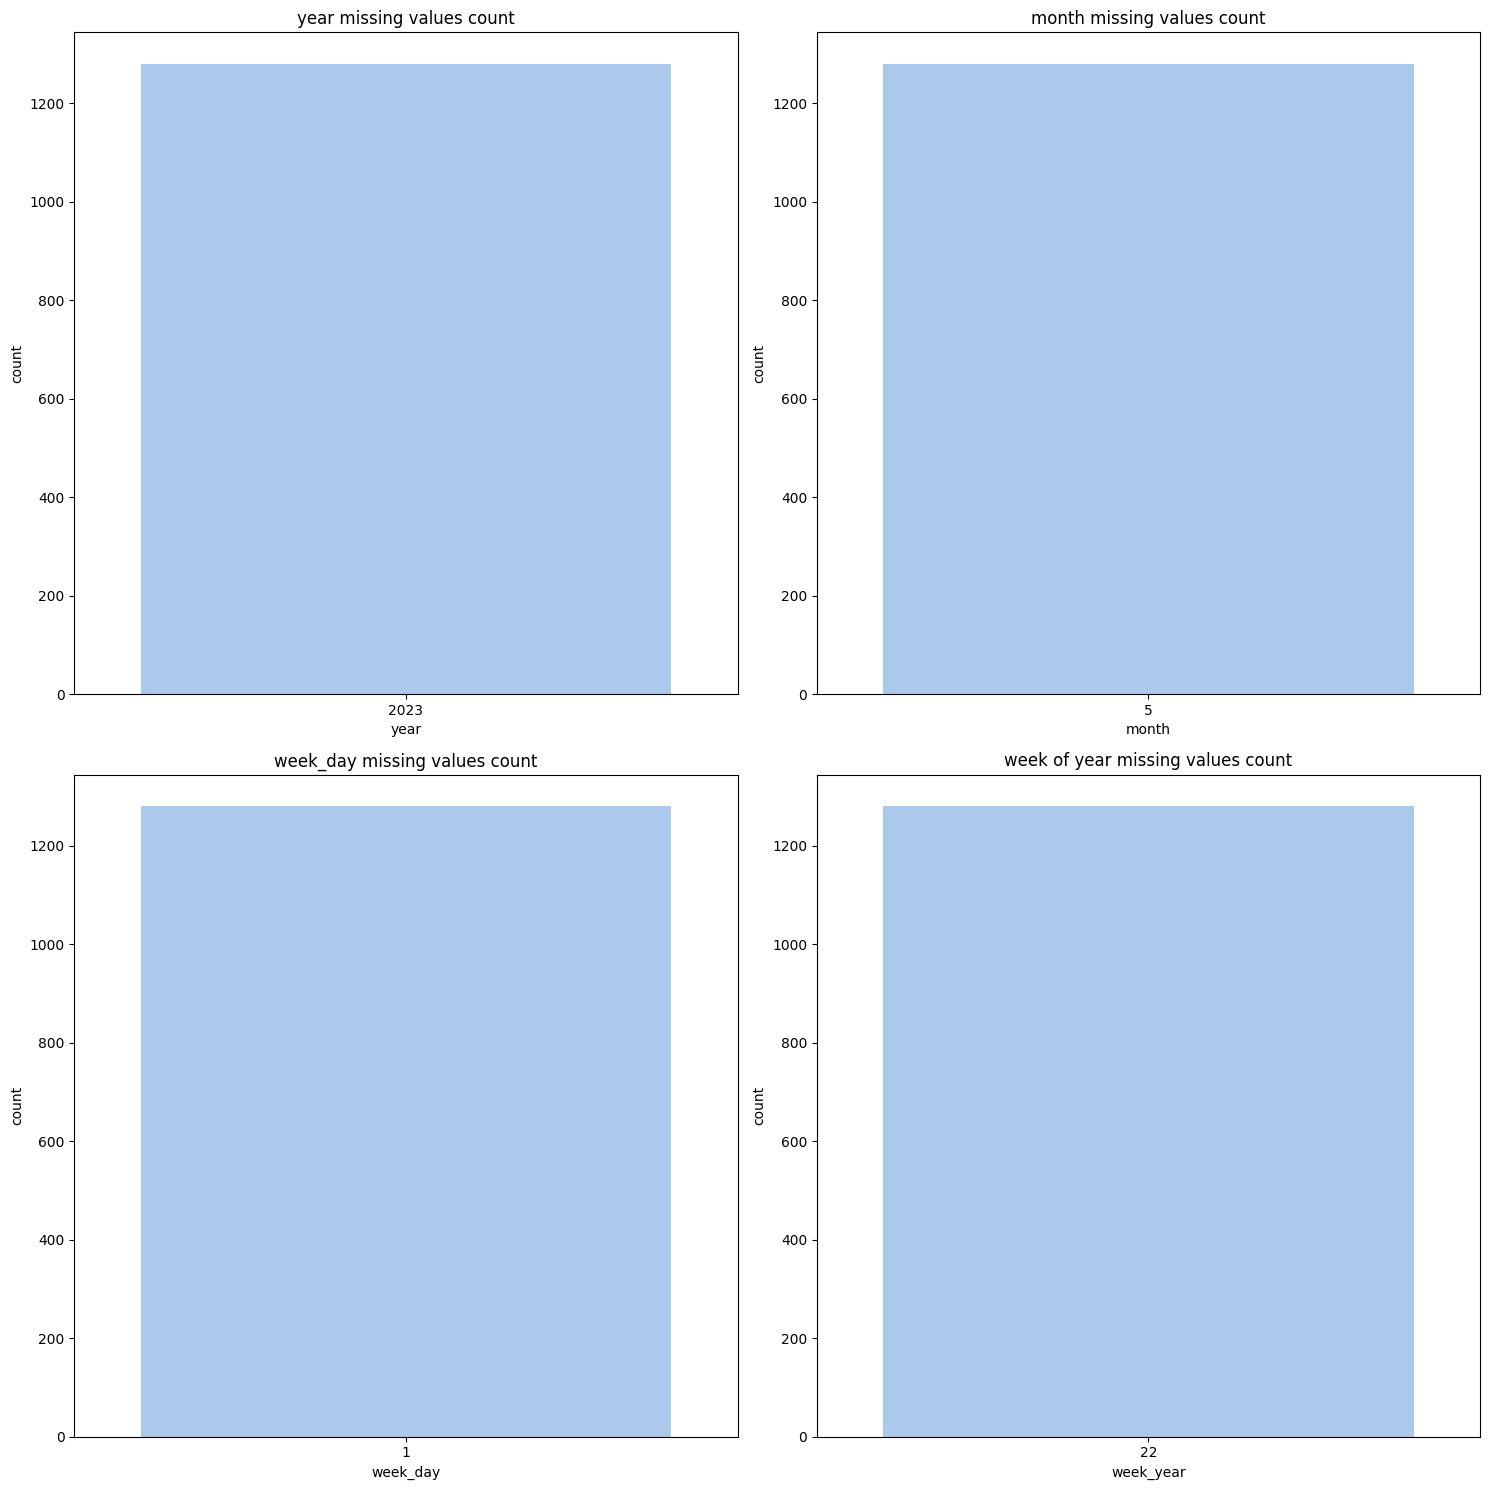

In [27]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,15))


sns.countplot(data=gas_missing, x='year', ax=ax1, palette='pastel')
ax1.set_title('year missing values count')

sns.countplot(data=gas_missing, x='month', ax=ax2, palette='pastel')
ax2.set_title('month missing values count')

sns.countplot(data=gas_missing, x='week_day', ax=ax3, palette='pastel')
ax3.set_title('week_day missing values count')

sns.countplot(data=gas_missing, x='week_year', ax=ax4, palette='pastel')
ax4.set_title('week of year missing values count')

plt.tight_layout()
plt.show()

### 3.1.3 - Deal with missing values

In [28]:
df_merged4 = df_merged3.copy()

# Drop rows with missing values for the following features: target and lowest_price_per_mwh
df_merged4 = df_merged4.dropna(subset=['target','lowest_price_per_mwh'])

In [29]:
#Check that there is no more missing values in our main dataset
dataset_presentation(df_merged4)

                    
                    
General introduction
                    
Shape : (1980930, 27)
                    
--------------------
county is the following type : int64
county percentage missinge value : 0.0%
--------------------
--------------------
is_business is the following type : int64
is_business percentage missinge value : 0.0%
--------------------
--------------------
product_type is the following type : int64
product_type percentage missinge value : 0.0%
--------------------
--------------------
target is the following type : float64
target percentage missinge value : 0.0%
--------------------
--------------------
is_consumption is the following type : int64
is_consumption percentage missinge value : 0.0%
--------------------
--------------------
prediction_unit_id is the following type : int64
prediction_unit_id percentage missinge value : 0.0%
--------------------
--------------------
date is the following type : datetime64[ns]
date percentage missinge value

## 3.2 - Dupplicates

In [30]:
#Check the dupplicates
df_merged4.duplicated().sum()

0

## 3.3 - Value type

In [31]:
#Check the features types
df_merged4.dtypes

county                             int64
is_business                        int64
product_type                       int64
target                           float64
is_consumption                     int64
prediction_unit_id                 int64
date                      datetime64[ns]
temperature                      float64
dewpoint                         float64
rain                             float64
snowfall                         float64
surface_pressure                 float64
cloudcover_total                 float64
cloudcover_low                   float64
cloudcover_mid                   float64
cloudcover_high                  float64
windspeed_10m                    float64
winddirection_10m                float64
shortwave_radiation              float64
direct_solar_radiation           float64
diffuse_radiation                float64
latitude                         float64
longitude                        float64
data_block_id                    float64
euros_per_mwh   

In [32]:
#Drop date type feature
df_merged4.head().drop(columns='date',inplace=True)
df_merged4.head()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/2267066292.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged4.head().drop(columns='date',inplace=True)


,county,is_business,product_type,target,is_consumption,prediction_unit_id,date,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
2021-09-01,0,0,1,0.713,0,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,1,96.590,1,0,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,2,0.000,0,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,2,17.314,1,1,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32
2021-09-01,0,0,3,2.904,0,2,2021-09-01,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32


## 3.4 - Target visualisation

In [33]:
#Create 2 datasets, one for the production and one for the consumption
df_merged4_cons = df_merged4[df_merged4['is_consumption']==1]
df_merged4_prod = df_merged4[df_merged4['is_consumption']==0]

In [34]:
#Use log1 transformation since the target is right-skewed
df_merged4_cons['target_log']=np.log1p(df_merged4_cons['target'])
df_merged4_prod['target_log']=np.log1p(df_merged4_prod['target'])

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/156430293.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged4_cons['target_log']=np.log1p(df_merged4_cons['target'])
/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/156430293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged4_prod['target_log']=np.log1p(df_merged4_prod['target'])


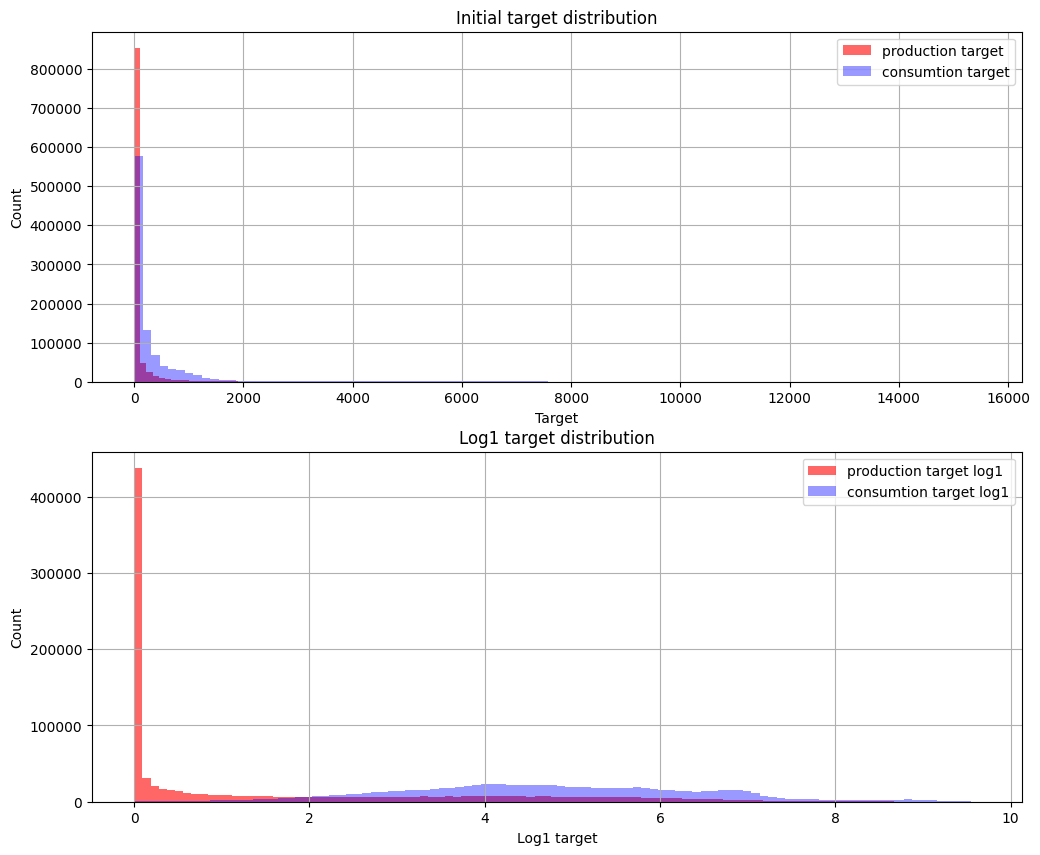

In [35]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,10))

ax1.hist(df_merged4_prod['target'], bins=100, label='production target',color='r',alpha=0.6)
ax1.hist(df_merged4_cons['target'], bins=100, label='consumtion target',color='b',alpha=0.4)
ax1.set_title('Initial target distribution')
ax1.set_xlabel('Target')
ax1.set_ylabel('Count')
ax1.grid()
ax1.legend()

ax2.hist(df_merged4_prod['target_log'], bins=100, label='production target log1',color='r',alpha=0.6)
ax2.hist(df_merged4_cons['target_log'], bins=100, label='consumtion target log1',color='b',alpha=0.4)
ax2.set_title('Log1 target distribution')
ax2.set_xlabel('Log1 target')
ax2.set_ylabel('Count')
ax2.grid()
ax2.legend()

plt.show()

## 3.5 - Feature engineering

In [36]:
df_merged5 = df_merged4.copy()

# Add bacic date features
df_merged5['year'] = df_merged5.index.year
df_merged5['month'] = df_merged5.index.month
df_merged5['week'] = df_merged5.index.weekofyear
df_merged5['day'] = df_merged5.index.day
df_merged5['hour'] = df_merged5.index.hour
df_merged5['weekday'] = df_merged5.index.weekday

df_merged5.reset_index(inplace=True)
df_merged5.drop(columns=['index','date','prediction_unit_id'],inplace=True)

df_merged5.head()

/var/folders/qx/vs5kgv557012y73k70gg87640000gn/T/ipykernel_7199/3496135809.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df_merged5['week'] = df_merged5.index.weekofyear


,county,is_business,product_type,target,is_consumption,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh,year,month,week,day,hour,weekday
0,0,0,1,0.713,0,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32,2021,9,35,1,0,2
1,0,0,1,96.590,1,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32,2021,9,35,1,0,2
2,0,0,2,0.000,0,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32,2021,9,35,1,0,2
3,0,0,2,17.314,1,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32,2021,9,35,1,0,2
4,0,0,3,2.904,0,13.6,10.6,0.0,0.0,1008.433333,58.833333,61.5,4.166667,3.833333,4.972222,340.0,0.0,0.0,0.0,59.3,24.866667,1.0,92.51,45.23,46.32,2021,9,35,1,0,2


In [37]:
# Add cyclical features
df_merged5['month_cyclical'] = df_merged5['month'].apply(lambda x: np.sin(2 * np.pi * x / 12))
df_merged5['week_cyclical'] = df_merged5['month'].apply(lambda x: np.sin(2 * np.pi * x / 7))
df_merged5['year_cyclical'] = df_merged5['month'].apply(lambda x: np.sin(2 * np.pi * x / 365))
df_merged5['hour_cyclical'] = df_merged5['month'].apply(lambda x: np.sin(2 * np.pi * x / 24))

# Add season features
df_merged5['season'] = 0
df_merged5.loc[df_merged5['month'].isin([3, 4,5]), 'season'] = 2 #spring
df_merged5.loc[df_merged5['month'].isin([6, 7,8]), 'season'] = 3 #summer
df_merged5.loc[df_merged5['month'].isin([9, 10,11]), 'season'] = 4 #fall
df_merged5.loc[df_merged5['month'].isin([12, 1,2]), 'season'] = 1 #winter

# Add weekend features
df_merged5['weekend'] = 0
df_merged5.loc[df_merged5['weekday'].isin([1,2,3,4,0]), 'weekend'] = 0
df_merged5.loc[df_merged5['weekday'].isin([6,5]), 'weekend'] = 1

# Add day and night features
df_merged5['is_night'] = ''

sunrise_sunset = {
    1: {'sunrise': 9, 'sunset': 16},  # January
    2: {'sunrise': 8, 'sunset': 16},  # February
    3: {'sunrise': 7, 'sunset': 19},  # March
    4: {'sunrise': 6, 'sunset': 20},  # April
    5: {'sunrise': 5, 'sunset': 21},  # Mai
    6: {'sunrise': 4, 'sunset': 23},  # June
    7: {'sunrise': 4, 'sunset': 22},  # July
    8: {'sunrise': 5, 'sunset': 21},  # August
    9: {'sunrise': 6, 'sunset': 20},  # Sept
    10: {'sunrise': 7, 'sunset': 19},  # Oct
    11: {'sunrise': 8, 'sunset': 17},  # Nov
    12: {'sunrise': 9, 'sunset': 16}   # Dec
}

def is_night(row):
    month = row['month']
    hour = row['hour']
    sunrise = sunrise_sunset[month]['sunrise']
    sunset = sunrise_sunset[month]['sunset']
    return 1 if hour < sunrise or hour >= sunset else 0

df_merged5['is_night'] = df_merged5.apply(is_night, axis=1)


# Add special Estonian events features

events = {
    (2, 24): 'Jour de l\'Indépendance',
    (4, 1): 'Fête du Travail',
    (6, 23): 'Journée de la Victoire',
    (6, 24): 'Fête de la Saint-Jean',
    (8, 20): 'Journée de l\'Indépendance',
    (12, 24): 'Noël',
    (12, 25): 'Noël',
    (12, 31): 'Saint-Sylvestre'
}

# Fonction pour vérifier si une date correspond à un événement
events = {
    (2, 24): 'Independence Day',
    (4, 1): 'Labor Day',
    (6, 23): 'Victory Day',
    (6, 24): 'St. John\'s Day',
    (8, 20): 'Restoration of Independence Day',
    (12, 24): 'Christmas',
    (12, 25): 'Christmas',
    (12, 31): 'New Year\'s Eve'
}

# Function to check if a date corresponds to an event
def is_event(month, day):
    return 1 if (month, day) in events else 0

# Create a new column 'event' with 1 for special events and 0 otherwise
df_merged5['event'] = df_merged5.apply(lambda row: is_event(row['month'], row['day']), axis=1)

# 5 - Train/Test split

In [38]:
df_merged6 = df_merged5.copy()

In [39]:
#Train size will be 80% of the data set length
train_size = int(df_merged6.shape[0]*0.8)

#Create train and test set
train_df = df_merged6.iloc[:train_size]
test_df = df_merged6.iloc[train_size:]

#Create Xtrain and ytrain from trainset
X_train = train_df.drop(columns='target')
y_train = train_df['target']

#Create Xtest and ytest from trainset
X_test = test_df.drop(columns='target')
y_test = test_df['target']

assert train_df.shape[0] + test_df.shape[0] == df_merged6.shape[0], "The is a problem in the split of the test and train set"

print('Below are the different shape of the datasets:')
print(f'Shape of train + test set :{train_df.shape[0] + test_df.shape[0] }')
print(f'Shape of merged set :{df_merged6.shape[0]}')

Below are the different shape of the datasets:
Shape of train + test set :1980930
Shape of merged set :1980930


# 6 - Models

In [40]:
#Create 2 lists to store both the model scores and model names
mae_scores = []
model_names = []

## 6.1 - Baseline

In [41]:
#We define the baseline as the mean of the y_test
mean_y = y_train.mean()
ypred_baseline = pd.Series([mean_y] * len(y_train))

In [43]:
mean_y

258.29904912843966

In [42]:
#Calculate the baseline score
mae_baseline = mean_absolute_error(y_train, ypred_baseline)
mae_baseline

351.8642800505902

In [46]:
#Insert score and names in the lists
mae_scores.append(mae_baseline)
model_names.append('Baseline')

In [47]:
def baseline_comp (ybase, ypred, ytest):
    ''' A small function to compare the score of a model to the baseline score
    '''
    mae_base =  mean_absolute_error(y_test, ybase)
    mae_pred = mean_absolute_error(y_test, ypred)

    mae_diff = np.round((abs(mae_base - mae_pred) / mae_base) * 100,2)

    print(f'The MAE baseline is {mae_baseline}')
    print(f'The MAE for y_pred is {mae_pred}')

    if mae_diff >= 80:
        print('Amazing prediction compared to the baseline model 🚀')
        print(f'The Progression with this prediction from the baseline model is: {mae_diff} %')

    if mae_diff >= 40 and mae_diff < 80 :
        print('Good job compared to the baseline model ✅')
        print(f'The Progression with this prediction from the baseline model is: {mae_diff} %')

    if mae_diff < 40:
        print('Well done, im sure you can do better 👉')
        print(f'The Progression with this prediction from the baseline model is: {mae_diff} %')

    return mae_base, mae_pred, mae_diff

## 6.2 - Random Forest

In [59]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred = rf_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)

print("Mean Absolute Error (MAE) du modèle Random Forest:", mae)

Mean Absolute Error (MAE) du modèle Random Forest: 101.98272453824715


In [60]:
baseline_comp(ypred_baseline, y_pred, y_test)

The MAE baseline is 444.1297627564832
The MAE for y_pred is 101.98272453824715
Good job compared to the baseline model ✅
The Progression with this prediction from the baseline model is: 77.04 %


(444.1297627564832, 101.98272453824715, 77.04)

In [61]:
#Insert score and names in the lists
mae_scores.append(mae)
model_names.append('Random Forest')

## 6.3 - LGBM

In [48]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Model params
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'early_stopping_round': 100
}

# Train model
model = lgb.train(params,
                  train_data,
                  valid_sets=[test_data],
                  num_boost_round=1000)

# Predict
y_pred_lgbm = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
print(f'Mean Absolute Error: {mae_lgbm}')

# Show most important features
importances = model.feature_importance()
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feature_importance_df.sort_values(by='importance', ascending=False))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4694
[LightGBM] [Info] Number of data points in the train set: 1584744, number of used features: 38
[LightGBM] [Info] Start training from score 258.299049
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's l1: 92.9323
Mean Absolute Error: 92.93231928592674
                   feature  importance
0                   county        3593
2             product_type        3257
20           data_block_id        2002
18                latitude        1990
1              is_business        1980
3           is_consumption        1752
19               longitude        1599
28                    hour        1438
29                 weekday        1342
15     shortwave_radia

In [49]:
#Insert score and names in the lists
mae_scores.append(mae_lgbm)
model_names.append('LGBM')

In [50]:
# Create a new dataset in order to plot the prediction

pred_concat = pd.concat([y_train, pd.Series(y_pred_lgbm)], ignore_index=True)

df_merged4_reset = df_merged4.reset_index(drop=True)
pred_concat_reset = pred_concat.reset_index(drop=True)

df_pred_concat = pd.concat([df_merged4_reset, pred_concat_reset], axis=1)
df_pred_concat = df_pred_concat.rename(columns={0: 'predicted'})
df_pred_concat['target2'] = df_pred_concat['target']

df_pred_concat.loc[:train_size-1, 'predicted'] = np.nan
df_pred_concat.loc[:train_size-1, 'target2'] = np.nan
df_pred_concat.loc[train_size:, 'target'] = np.nan

df_concat_grouped = df_pred_concat.groupby(by=['date']).mean()


# Create another dataset to focus on predicted and actual data

y_test2 = pd.Series(y_test).reset_index(drop=True)
y_pred_lgbm2 = pd.Series(y_pred_lgbm).reset_index(drop=True)

df = pd.concat([y_test2, y_pred_lgbm2], axis=1)
df = df.rename(columns={0: 'predicted'})

df_merged4_reset2 = df_merged4_reset.loc[train_size:]
df_merged4_reset2 = df_merged4_reset2.reset_index(drop=True)

df_pred_concat2 = pd.concat([df_merged4_reset2, df], axis=1)

df_concat_grouped2 = df_pred_concat2.groupby(by=['date']).mean()


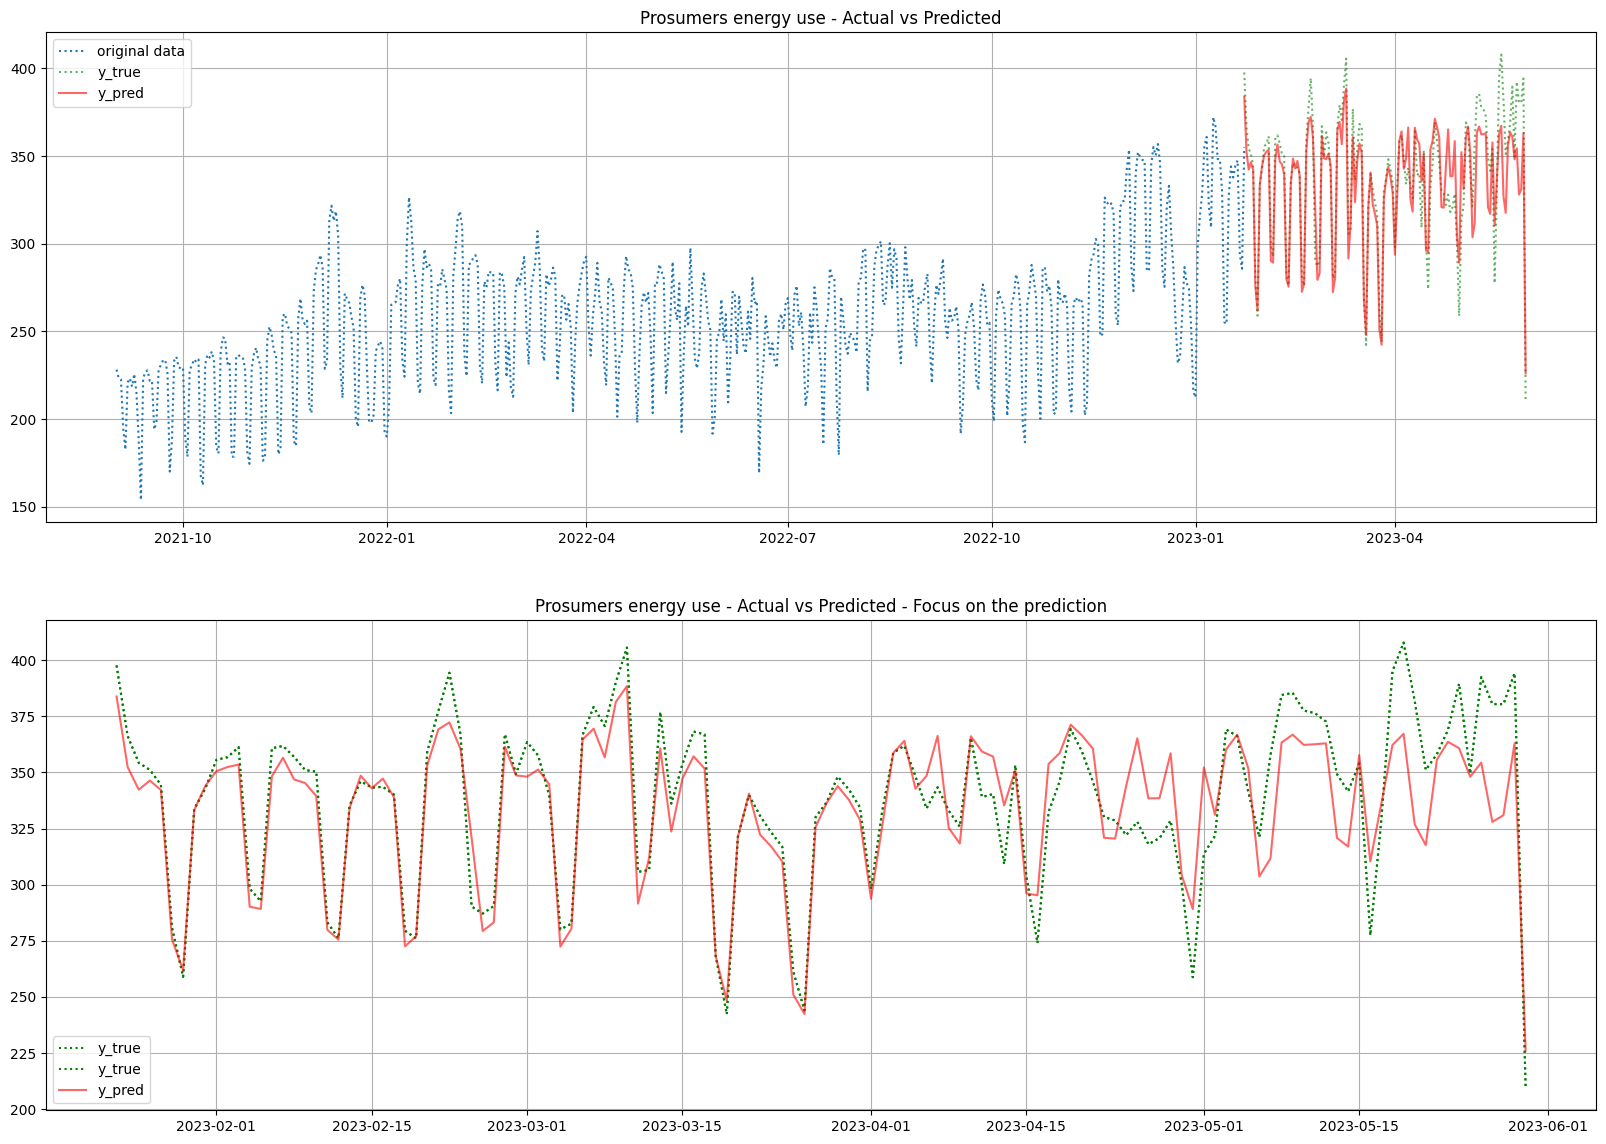

In [51]:
#Plot original data and predicted data
fig, (ax1,ax2) = plt.subplots(ncols=1,nrows=2, figsize=(20,14))

ax1.plot(df_concat_grouped['target'], label='original data', linestyle=':')
ax1.plot(df_concat_grouped['target2'], label='y_true', color='green',linestyle=':',alpha=0.6)
ax1.plot(df_concat_grouped['predicted'], label='y_pred', color='r', alpha=0.6)
ax1.set_title('Prosumers energy use - Actual vs Predicted')
ax1.legend()
ax1.grid()

ax2.plot(df_concat_grouped2['target'], label='y_true', color='green', linestyle=':')
ax2.plot(df_concat_grouped2['predicted'], label='y_pred', color='r', alpha=0.6)
ax2.set_title('Prosumers energy use - Actual vs Predicted - Focus on the prediction')
ax2.legend()
ax2.grid()

plt.show()

### 6.3.1 - Grid Search and model optimization

In [63]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

# Model
model = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mae')

# Gridsearch params
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.05, 0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'feature_fraction': [0.8, 0.9, 1.0]
}

# Time Serie split
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

# Train the model
grid_result = grid_search.fit(X_train, y_train)

# Show the best params
print("Best parameters found: ", grid_result.best_params_)
print("Best MAE score: ", -grid_result.best_score_)

# Train model with best params
best_model = grid_result.best_estimator_
best_model.fit(X_train, y_train)

# Predict
y_pred_lgbm = best_model.predict(X_test)

# Calculate MAE
mae_score_opt = mean_absolute_error(y_test, y_pred_lgbm)
print(f'The MAE score for the best model is {mae_score_opt}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3992
[LightGBM] [Info] Number of data points in the train set: 264124, number of used features: 35
[LightGBM] [Info] Start training from score 220.949761
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_frac

/Users/kevinboulliat/.pyenv/versions/lewagon/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.169065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4674
[LightGBM] [Info] Number of data points in the train set: 1056496, number of used features: 38
[LightGBM] [Info] Start training from score 248.219178
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[CV] END feature_fraction=0.8, learning_rate=0.05, n_estimators=1000, num_leaves=70; total tim

In [64]:
#Insert score and names in the lists
mae_scores.append(mae_score_opt)
model_names.append('LGBM optimized')

## 6.4 - XGboost

In [52]:
# Convert train and test to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Model params
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.9
}

# Train model
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 1000
model = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=100)

# Preidct
y_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae_xgb}')

# Show the most important features
importances = model.get_score(importance_type='weight')
importances_df = pd.DataFrame({'feature': importances.keys(), 'importance': importances.values()})
print(importances_df.sort_values(by='importance', ascending=False))

/Users/kevinboulliat/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/core.py:568: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[0]	eval-mae:333.67695	train-mae:254.63737
[1]	eval-mae:328.45192	train-mae:251.09003
[2]	eval-mae:315.42346	train-mae:239.16107
[3]	eval-mae:314.21255	train-mae:238.66863
[4]	eval-mae:301.56193	train-mae:227.76406
[5]	eval-mae:289.50008	train-mae:217.49762
[6]	eval-mae:289.53120	train-mae:217.95990
[7]	eval-mae:279.73735	train-mae:209.00541
[8]	eval-mae:277.38323	train-mae:207.45759
[9]	eval-mae:267.74765	train-mae:198.62940
[10]	eval-mae:261.97343	train-mae:193.68148
[11]	eval-mae:254.05454	train-mae:185.94698
[12]	eval-mae:246.11937	train-mae:178.81031
[13]	eval-mae:238.79526	train-mae:172.26920
[14]	eval-mae:232.19337	train-mae:166.00926
[15]	eval-mae:226.23953	train-mae:160.39666
[16]	eval-mae:220.81643	train-mae:155.20751
[17]	eval-mae:215.71709	train-mae:150.49879
[18]	eval-mae:210.52037	train-mae:145.83508
[19]	eval-mae:206.09684	train-mae:141.76858
[20]	eval-mae:201.64008	train-mae:138.02426
[21]	eval-mae:197.55352	train-mae:134.18312
[22]	eval-mae:194.10613	train-mae:131.2404

/Users/kevinboulliat/.pyenv/versions/lewagon/lib/python3.10/site-packages/xgboost/core.py:91: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


Mean Absolute Error: 109.25469355591214
                   feature  importance
2             product_type      9944.0
0                   county      7633.0
3           is_consumption      7363.0
1              is_business      5952.0
18                latitude      4196.0
19               longitude      3760.0
20           data_block_id      2501.0
15     shortwave_radiation      2178.0
28                    hour      1710.0
29                 weekday      1660.0
4              temperature      1507.0
16  direct_solar_radiation      1363.0
5                 dewpoint      1113.0
21           euros_per_mwh      1104.0
26                    week      1100.0
17       diffuse_radiation      1095.0
8         surface_pressure      1064.0
22    lowest_price_per_mwh       728.0
13           windspeed_10m       645.0
23   highest_price_per_mwh       631.0
14       winddirection_10m       612.0
27                     day       482.0
33           hour_cyclical       426.0
36                is_nig

In [53]:
#Insert score and names in the lists
mae_scores.append(mae_xgb)
model_names.append('XGB')

## 6.5 - Linear Regression

In [54]:
#Scale data before linear regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
#Train
model = LinearRegression()
model.fit(X_train_scaled, y_train)

#Predict
y_pred = model.predict(X_test_scaled)

#Evaluate
mae_reg = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae_reg}')

Mean Absolute Error: 414.55954434216966


In [56]:
#Insert score and names in the lists
mae_scores.append(mae_reg)
model_names.append('Linear Regression')

# 7 - Results

In [65]:
model_scores = {
    'Model Name':model_names ,
    'MAE Score': mae_scores
}

df_model_scores = pd.DataFrame(model_scores)
df_model_scores.sort_values(by='MAE Score')

,Model Name,MAE Score
5,LGBM optimized,88.340829
1,LGBM,92.932319
4,Random Forest,101.982725
2,XGB,109.254694
3,Linear Regression,414.559544
0,Baseline,444.129763
